In [1]:
# File: ResNet50_Model.ipynb
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

In [2]:
#  Download & Extract Dataset

print("--- Downloading and Extracting Dataset ---")

zip_path = tf.keras.utils.get_file(
    origin='https://zenodo.org/records/16749554/files/PY-CrackDB.zip?download=1',
    fname='PY-CrackDB.zip',
    extract=True,
    archive_format='zip'
)

base_dir = os.path.dirname(zip_path)
extracted_dir_name = 'PY-CrackDB_extracted'
data_dir = os.path.join(base_dir, extracted_dir_name, 'Classification')

print("Dataset ready at:", data_dir)

--- Downloading and Extracting Dataset ---
48062153/48062153 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Dataset ready at: /root/.keras/datasets/PY-CrackDB_extracted/Classification


In [3]:
#  Parameters


IMG_WIDTH, IMG_HEIGHT = 224, 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32
NUM_CLASSES = 2
VALIDATION_SPLIT = 0.2

EPOCHS_HEAD = 5
EPOCHS_FINE_TUNE = 15
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINE_TUNE = 1e-5

In [4]:
#  Data Augmentation


train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

class_labels = list(train_generator.class_indices.keys())
print("Classes:", class_labels)


Found 456 images belonging to 2 classes.
Found 113 images belonging to 2 classes.
Classes: ['With crack', 'Without crack']


In [5]:
#  Build ResNet50 Model (Transfer Learning)

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
)

base_model.trainable = False

inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
#  Train Classification Head

print("\n--- Training Classification Head ---")
model.compile(
    optimizer=Adam(LEARNING_RATE_HEAD),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

t1 = time.time()
history_head = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_HEAD
)
t2 = time.time()
print(f"Head training time: {t2 - t1:.2f}s")



--- Training Classification Head ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 116s 8s/step - accuracy: 0.6370 - loss: 1.2573 - val_accuracy: 0.9479 - val_loss: 0.1099
Epoch 2/5
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1:04 5s/step - accuracy: 0.8750 - loss: 0.4194

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8750 - loss: 0.4194 - val_accuracy: 0.9688 - val_loss: 0.0810
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.9461 - loss: 0.1556 - val_accuracy: 0.9688 - val_loss: 0.0823
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9688 - loss: 0.1314 - val_accuracy: 0.9896 - val_loss: 0.0438
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - accuracy: 0.9920 - loss: 0.0374 - val_accuracy: 0.9792 - val_loss: 0.0219
Head training time: 449.45s


In [7]:
#  Fine-Tuning (Unfreeze last blocks)


print("\n--- Fine-tuning ResNet50 ---")

base_model.trainable = True


for layer in base_model.layers:
    if "conv5_block1" in layer.name:
        layer.trainable = True

model.compile(
    optimizer=Adam(LEARNING_RATE_FINE_TUNE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

t3 = time.time()
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_FINE_TUNE,
    initial_epoch=history_head.epoch[-1]
)
t4 = time.time()

total_train_time = (t2 - t1) + (t4 - t3)
print(f"Fine-tuning time: {t4 - t3:.2f}s")
print(f"Total training time: {total_train_time:.2f}s")



--- Fine-tuning ResNet50 ---
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 398s 24s/step - accuracy: 0.9537 - loss: 0.1419 - val_accuracy: 0.9896 - val_loss: 0.0255
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 1.0000 - loss: 0.0200 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 376s 23s/step - accuracy: 0.9942 - loss: 0.0231 - val_accuracy: 0.9792 - val_loss: 0.0793
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 1.0000 - loss: 0.0260 - val_accuracy: 0.9896 - val_loss: 0.0265
Epoch 9/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 329s 23s/step - accuracy: 0.9777 - loss: 0.0387 - val_accuracy: 0.9688 - val_loss: 0.0743
Epoch 10/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 1.0000 - loss: 0.0235 - val_accuracy: 0.9792 - val_loss: 0.0721
Epoch 11/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 382s 26s/step - accuracy: 0.9978 - loss: 0.0122 - val_accuracy: 0.9792 - val_loss: 0.0895
Epoch 12/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 1.0000 - loss: 

In [13]:
#  Evaluation

print("\n--- Evaluating Model ---")

eval_datagen = ImageDataGenerator(validation_split=VALIDATION_SPLIT)

evaluation_generator = eval_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

t5 = time.time()
Y_pred_probs = model.predict(evaluation_generator, steps=evaluation_generator.samples)
Y_pred = np.argmax(Y_pred_probs, axis=1)
Y_true = evaluation_generator.classes
t6 = time.time()

print(f"Evaluation time: {t6 - t5:.2f}s")



--- Evaluating Model ---
Found 113 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 295ms/step
Evaluation time: 33.40s


In [14]:
# --- Accuracy ---

accuracy = accuracy_score(Y_true, Y_pred)
print(f"\nOverall Accuracy: {accuracy*100:.2f}%")



Overall Accuracy: 97.35%


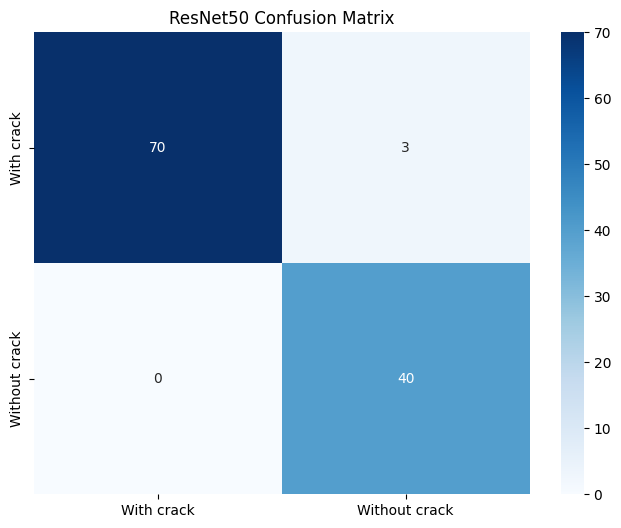

In [10]:
# --- Confusion Matrix ---

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("ResNet50 Confusion Matrix")
plt.show()

In [11]:
# --- Class Report ---

print("\nClassification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_labels))



Classification Report:
               precision    recall  f1-score   support

   With crack       1.00      0.96      0.98        73
Without crack       0.93      1.00      0.96        40

     accuracy                           0.97       113
    macro avg       0.97      0.98      0.97       113
 weighted avg       0.98      0.97      0.97       113




--- ROC & AUC ---
AUC Score: 1.0


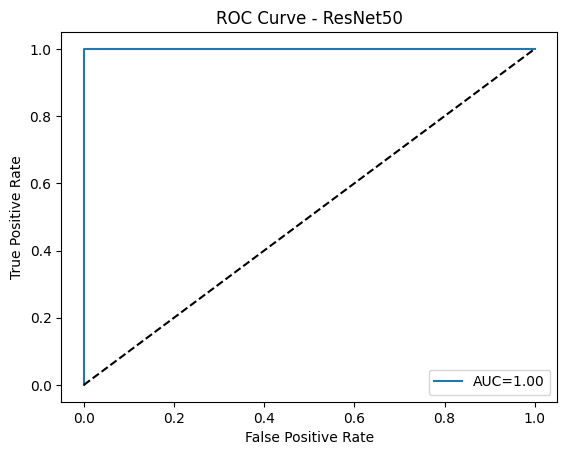


Model saved as resnet50_fine_tuned_model.h5


In [12]:
# --- AUC + ROC ---

print("\n--- ROC & AUC ---")
positive_probs = Y_pred_probs[:, 1]
auc = roc_auc_score(Y_true, positive_probs)
print("AUC Score:", auc)

fpr, tpr, _ = roc_curve(Y_true, positive_probs)
plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve - ResNet50")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


#  Save Model

model.save("resnet50_fine_tuned_model.h5")
print("\nModel saved as resnet50_fine_tuned_model.h5")